# Classification

## NOTE : THIS PART OF THE CODE SNIPPETS ARE THE PART OF THE INFORMATION TECHNOLOGY PROJECT OF  HTET AUNG (522K0048) AND HSU MYAT WAI MAUNG (522K0049)  FROM FACULTY OF INFORMATION TECHNOLOGY UNDER THE SUPERVISION OF TON DUC THANG UNIVERSITY.

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("meowmeowmeowmeowmeow/gtsrb-german-traffic-sign")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'gtsrb-german-traffic-sign' dataset.
Path to dataset files: /kaggle/input/gtsrb-german-traffic-sign


In [ ]:
# 3. Organize Data: Split 'train' into 'train_data' and 'val_data' for strict separation
import os
import shutil
import random
from pathlib import Path

# Paths
base_path = Path('/kaggle/input/gtsrb-german-traffic-sign')
original_train = base_path / 'train'
new_base = Path('gtsrb_formatted')
train_dir = new_base / 'train'
val_dir = new_base / 'val'

# Create directories
for class_id in os.listdir(original_train):
    os.makedirs(train_dir / class_id, exist_ok=True)
    os.makedirs(val_dir / class_id, exist_ok=True)

# Move 20% of files to validation
split_ratio = 0.2
print("Organizing dataset... (this may take a moment)")

for class_id in os.listdir(original_train):
    src_path = original_train / class_id
    files = os.listdir(src_path)
    random.shuffle(files)

    val_count = int(len(files) * split_ratio)

    # Move val files
    for f in files[:val_count]:
        shutil.copy(src_path / f, val_dir / class_id / f)

    # Move train files
    for f in files[val_count:]:
        shutil.copy(src_path / f, train_dir / class_id / f)

print(f"Data ready at: {new_base}")

Organizing dataset... (this may take a moment)
Data ready at: gtsrb_formatted


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications, optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import os

# --- Configuration ---
IMG_SIZE = (64, 64)  # 64x64 is good for GTSRB efficiency vs accuracy
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 43
INPUT_SHAPE = (64, 64, 3)

# --- Data Loading (Using your existing formatted directories) ---
# Ensure you have run the cell that creates 'gtsrb_formatted' first!
train_dir = 'gtsrb_formatted/train'
val_dir = 'gtsrb_formatted/val'

print("Loading datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False, # Important for evaluation order
    label_mode='int'
)

# --- Performance Optimization ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- Data Augmentation Layer ---
# Professional tip: Embed augmentation in the model so it runs on GPU
data_augmentation = models.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
], name="augmentation")

print("Data pipeline ready.")

Loading datasets...
Found 31368 files belonging to 43 classes.
Found 7841 files belonging to 43 classes.
Data pipeline ready.


In [ ]:
def create_custom_cnn():
    """
    A deeper custom CNN with BatchNormalization and Dropout for regularization.
    """
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = layers.Rescaling(1./255)(inputs)
    x = data_augmentation(x)

    # Block 1
    x = layers.Conv2D(32, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 2
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(64, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Block 3
    x = layers.Conv2D(128, (3, 3), padding='same', use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)

    # Head
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return models.Model(inputs, outputs, name="Custom_CNN")

def create_resnet50():
    """
    ResNet50 Transfer Learning.
    Note: ResNet expects specific preprocessing usually, but we will fine-tune.
    """
    inputs = layers.Input(shape=INPUT_SHAPE)
    # ResNet specific preprocessing
    x = applications.resnet50.preprocess_input(inputs)
    x = data_augmentation(x)

    base_model = applications.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=INPUT_SHAPE
    )
    # Freeze the base to prevent destroying learned features immediately
    base_model.trainable = False

    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return models.Model(inputs, outputs, name="ResNet50")

def create_efficientnet():
    """
    EfficientNetB0 - Often superior for image classification tasks.
    """
    inputs = layers.Input(shape=INPUT_SHAPE)
    x = data_augmentation(inputs)

    # EfficientNet has built-in rescaling, but we ensure inputs are 0-255
    base_model = applications.EfficientNetB0(
        include_top=False,
        weights='imagenet',
        input_shape=INPUT_SHAPE
    )
    base_model.trainable = False

    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

    return models.Model(inputs, outputs, name="EfficientNetB0")

## Train models

Loading datasets...
Found 31368 files belonging to 43 classes.
Found 7841 files belonging to 43 classes.
Data pipeline ready.

Training Custom_CNN...
Epoch 1/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 30s 37ms/step - accuracy: 0.1628 - loss: 3.0752 - val_accuracy: 0.2607 - val_loss: 2.5735 - learning_rate: 0.0010
Epoch 2/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 33ms/step - accuracy: 0.3377 - loss: 2.1965 - val_accuracy: 0.4897 - val_loss: 1.6204 - learning_rate: 0.0010
Epoch 3/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.4624 - loss: 1.6641 - val_accuracy: 0.5275 - val_loss: 1.4651 - learning_rate: 0.0010
Epoch 4/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.5583 - loss: 1.3510 - val_accuracy: 0.5396 - val_loss: 1.3801 - learning_rate: 0.0010
Epoch 5/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.6390 - loss: 1.0999 - val_accuracy: 0.7151 - val_loss: 0.8372 - learning_rate: 0.0010
Epoch 6/50
491/491 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - accuracy: 0.7137 - loss:

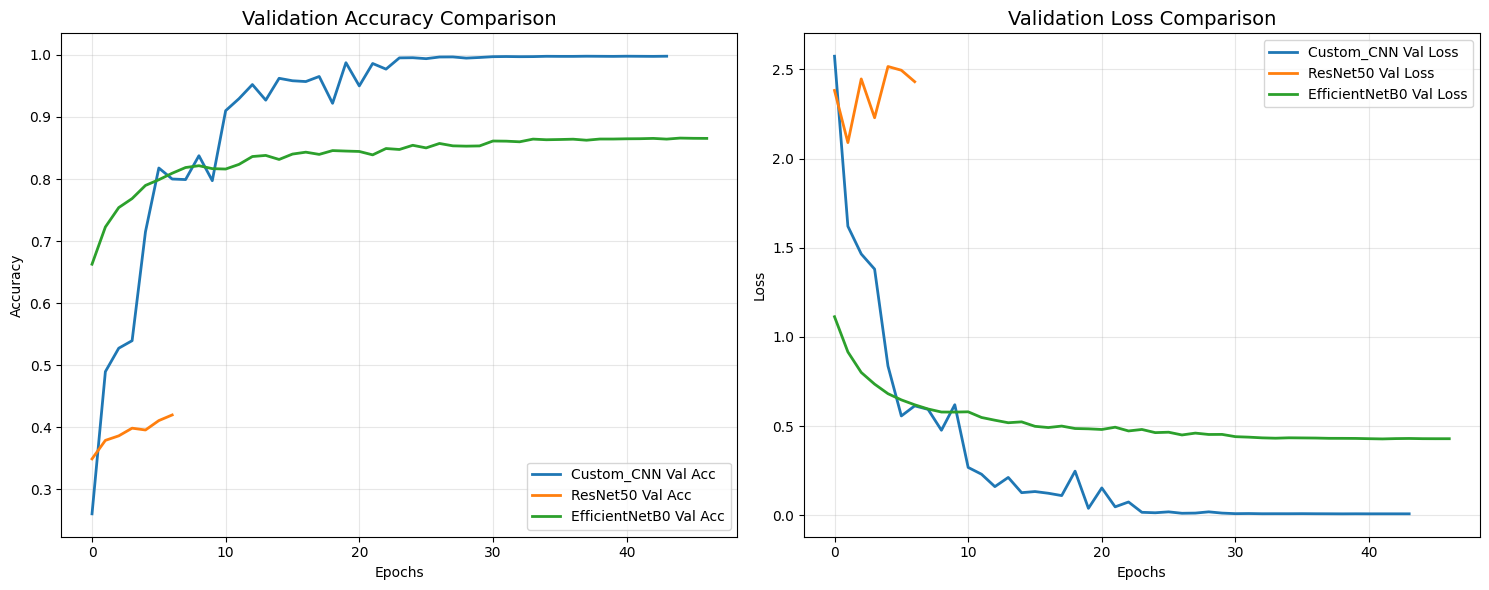

/tmp/ipython-input-4036763224.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(final_scores.keys()), y=list(final_scores.values()), palette='viridis')


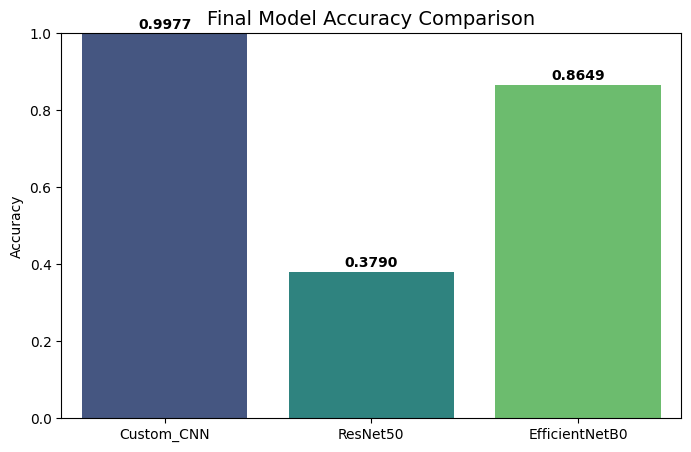


Performing Deep Analysis on the Best Model: Custom_CNN


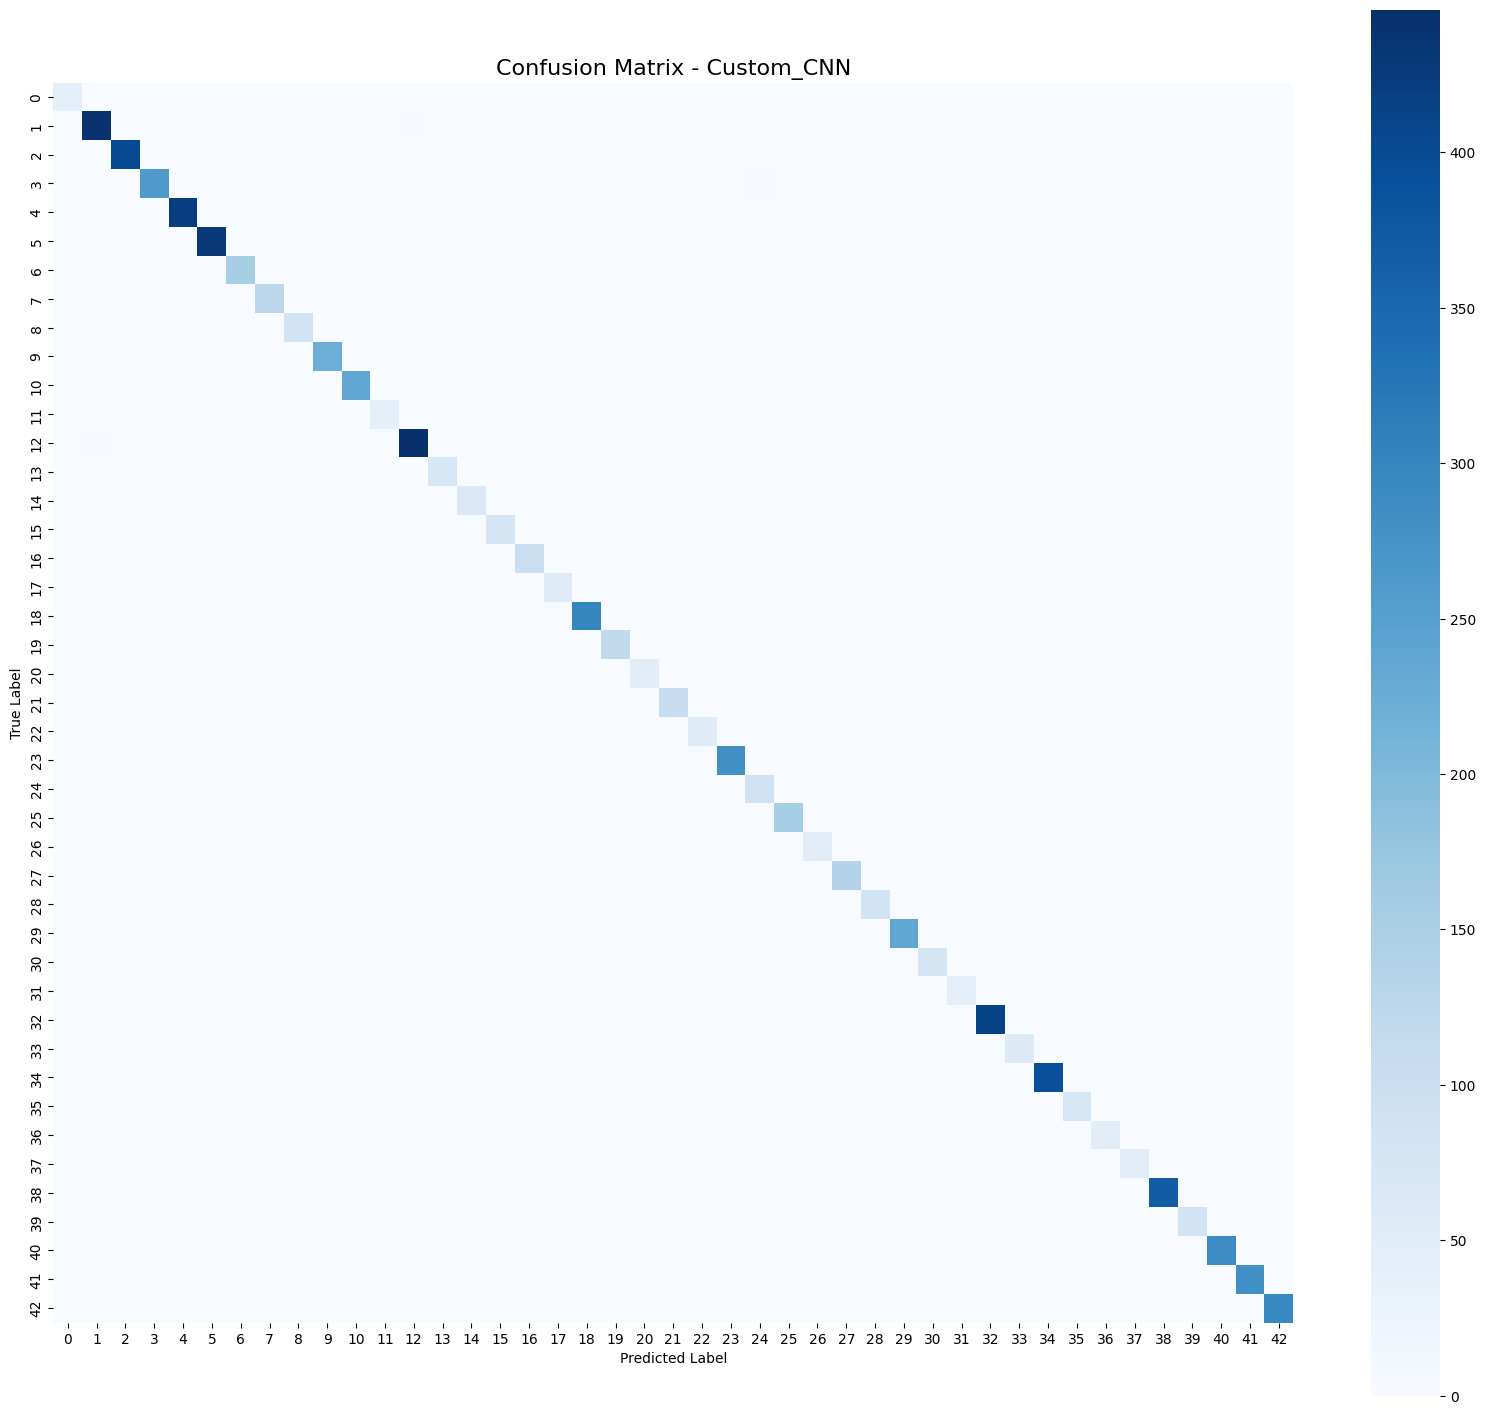

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        42
           1       0.99      1.00      0.99       444
           2       1.00      1.00      1.00       402
           3       1.00      0.99      0.99       264
           4       1.00      1.00      1.00       420
           5       1.00      1.00      1.00       432
           6       1.00      1.00      1.00       156
           7       1.00      1.00      1.00       126
           8       0.99      1.00      0.99        84
           9       1.00      1.00      1.00       222
          10       1.00      1.00      1.00       240
          11       1.00      1.00      1.00        42
          12       1.00      0.99      0.99       450
          13       1.00      0.99      0.99        72
          14       1.00      1.00      1.00        66
          15       1.00      1.00      1.00        78
          16       1.00      1.00      1.00       102
    

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, applications, optimizers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import os

# --- Configuration ---
IMG_SIZE = (64, 64)  # 64x64 is good for GTSRB efficiency vs accuracy
BATCH_SIZE = 64
EPOCHS = 50
NUM_CLASSES = 43
INPUT_SHAPE = (64, 64, 3)

# --- Data Loading (Using your existing formatted directories) ---
# Ensure you have run the cell that creates 'gtsrb_formatted' first!
train_dir = 'gtsrb_formatted/train'
val_dir = 'gtsrb_formatted/val'

print("Loading datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True,
    label_mode='int'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False, # Important for evaluation order
    label_mode='int'
)

# --- Performance Optimization ---
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# --- Data Augmentation Layer ---
# Professional tip: Embed augmentation in the model so it runs on GPU
data_augmentation = models.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
], name="augmentation")

print("Data pipeline ready.")

# Store histories and models for analysis
model_results = {}
models_list = [create_custom_cnn(), create_resnet50(), create_efficientnet()]

# Professional Callbacks
def get_callbacks(model_name):
    return [
        callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
        callbacks.ModelCheckpoint(f"best_{model_name}.keras", save_best_only=True, monitor='val_accuracy')
    ]

for model in models_list:
    print(f"\n{'='*40}")
    print(f"Training {model.name}...")
    print(f"{'='*40}")

    # Compile with optimal optimizer settings
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=EPOCHS,
        callbacks=get_callbacks(model.name),
        verbose=1
    )

    model_results[model.name] = {
        'history': history.history,
        'model': model
    }

print("\nAll models trained successfully!")

# --- 1. Comparative Accuracy & Loss Curves ---
plt.figure(figsize=(15, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
for name, res in model_results.items():
    plt.plot(res['history']['val_accuracy'], label=f"{name} Val Acc", linewidth=2)
plt.title('Validation Accuracy Comparison', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot Loss
plt.subplot(1, 2, 2)
for name, res in model_results.items():
    plt.plot(res['history']['val_loss'], label=f"{name} Val Loss", linewidth=2)
plt.title('Validation Loss Comparison', fontsize=14)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- 2. Bar Chart of Final Performance ---
final_scores = {}
for name, res in model_results.items():
    # Evaluate directly on validation set to get final numbers
    loss, acc = res['model'].evaluate(val_ds, verbose=0)
    final_scores[name] = acc

plt.figure(figsize=(8, 5))
sns.barplot(x=list(final_scores.keys()), y=list(final_scores.values()), palette='viridis')
plt.title('Final Model Accuracy Comparison', fontsize=14)
plt.ylim(0, 1.0) # Adjusted to show full range of accuracies
plt.ylabel('Accuracy')
for i, v in enumerate(final_scores.values()):
    plt.text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')
plt.show()

# --- 3. Deep Analysis: Confusion Matrix for the Best Model ---
# Find best model
best_model_name = max(final_scores, key=final_scores.get)
best_model = model_results[best_model_name]['model']
print(f"\nPerforming Deep Analysis on the Best Model: {best_model_name}")

# Get predictions
y_true = []
y_pred = []

# Iterate over val_ds to get labels and predictions
for images, labels in val_ds:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Confusion Matrix Heatmap
plt.figure(figsize=(20, 18))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', square=True) # annot=False because 43 classes is too crowded for text
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=16)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))